# 2025 Outpatient Clinical Data Analysis
## A Health Data Analytics Portfolio Project

**Author:** Data Analyst & Medical Doctor  
**Dataset:** Anonymised outpatient records from a major referral hospital in Kenya (2025)  
**Records:** 17,534 patient visits | **Period:** January 1 – December 31, 2025  

---

### Project Overview

This analysis examines a full year of outpatient visit records from a major Kenyan hospital. The dataset was anonymised prior to analysis in compliance with Kenya's Data Protection Act (2019) and patient confidentiality standards. All direct patient identifiers — names, phone numbers, dates of birth, and patient IDs — have been removed.

The analysis combines clinical domain expertise with Python-based data analytics to surface insights about disease burden, patient demographics, blood pressure screening coverage, and data quality — findings directly relevant to hospital management, clinical governance, and public health planning.

### Key Questions Investigated

1. What is the demographic profile of outpatient visitors?
2. What are the leading diagnoses and how do they distribute by gender?
3. What is the true hypertension burden when accounting for ICD-10 fragmentation?
4. Are there seasonal patterns in patient visit volumes?
5. What data quality issues exist and what are their clinical implications?

---
## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Chart styling
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

print('Libraries loaded successfully')

Libraries loaded successfully


In [2]:
# Load anonymised dataset
df = pd.read_csv('KSH_2025_outpatient_anonymised.csv')

# Fix data types
df['visit_date'] = pd.to_datetime(df['visit_date'])
df['systolic'] = pd.to_numeric(df['systolic'], errors='coerce')
df['diastolic'] = pd.to_numeric(df['diastolic'], errors='coerce')

print(f'Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns')
print(f'Date range: {df["visit_date"].min().date()} to {df["visit_date"].max().date()}')
df.head()

Dataset loaded: 17,534 rows, 13 columns
Date range: 2025-01-01 to 2025-12-31


,visit_date,age,gender,town,visit_type,diagnosis,systolic,diastolic,flag,investigations,prescriptions,diagnosis_clean,age_clean
0,2025-01-01,31 years,Male,NaN,New Patient,"Superficial injury of head,",120.0,78.0,Normal,"Consultation Fee Medical Officer,Grouping & Cr...","DIAZEPAM 5MG/ML 2MLS INJ,TETANUS VACCINE 0.5ML...",Superficial injury of head,31.00
1,2025-01-01,68 years,Male,NaN,Revisit,"Hypertensive urgency,",NaN,NaN,Normal,"REVIEW,Uecs,Hba1C,Lipid Profile,Inpatient Revi...","CEFTRIAXONE 1000MG I.V INJECTION,NIFEDIPINE RE...",Hypertensive urgency,68.00
2,2025-01-01,55 years,Female,NaN,Revisit,"Bell's palsy,",126.0,72.0,Normal,"REVIEW,Fasting Blood Sugar,Hba1C",NaN,Bell's palsy,55.00
3,2025-01-01,18 years,Male,NaN,Revisit,"Acute tonsillitis,",115.0,68.0,Normal,"Consultation Fee Medical Officer,Malaria Rapid...","AUGMENTIN TABLET 1GM,RILIF PLUS 500 100MG TABL...",Acute tonsillitis,18.00
4,2025-01-01,"8 years, 14 days",Male,NaN,New Patient,"Diarrhea, unspecified,",NaN,NaN,Normal,"Consultation Fee Medical Officer,Stool Examina...","ONDANSETRON 2MG/5ML SUSP. 50MLS,MONOFLAM (DICL...",Diarrhea,8.04


---
## 2. Data Quality Assessment

Before any analysis, a rigorous data quality audit is essential. In clinical datasets, data quality issues have direct implications for how findings should be interpreted and reported.

In [3]:
# Data completeness audit
print('=== DATA COMPLETENESS AUDIT ===')
print(f'{'Column':<25} {'Non-Null':>10} {'Missing':>10} {'Complete %':>12}')
print('-' * 60)
for col in df.columns:
    non_null = df[col].notna().sum()
    missing = df[col].isna().sum()
    pct = (non_null / len(df)) * 100
    print(f'{col:<25} {non_null:>10,} {missing:>10,} {pct:>11.1f}%')

=== DATA COMPLETENESS AUDIT ===
Column                      Non-Null    Missing   Complete %
------------------------------------------------------------
visit_date                    17,534          0       100.0%
age                           17,534          0       100.0%
gender                        17,507         27        99.8%
town                              66     17,468         0.4%
visit_type                    17,534          0       100.0%
diagnosis                     15,945      1,589        90.9%
systolic                      10,576      6,958        60.3%
diastolic                     10,559      6,975        60.2%
flag                          17,534          0       100.0%
investigations                16,478      1,056        94.0%
prescriptions                 13,127      4,407        74.9%
diagnosis_clean               15,945      1,589        90.9%
age_clean                     17,531          3       100.0%


### Data Quality Findings

The completeness audit reveals several important data quality issues with direct clinical and operational implications:

**Critical gaps:**
- **Town (99.6% missing):** Geographic data is virtually absent, making catchment area analysis impossible. This likely reflects a system configuration issue rather than deliberate omission.
- **Diagnosis (9.1% missing):** 1,589 visits have no recorded diagnosis. These may represent administrative or triage-only visits, but represent a documentation gap.
- **Prescriptions (25.1% missing):** Not every visit warrants a prescription, so this is partially expected. However, cross-referencing with diagnosis codes would be informative.
- **BP readings (38.9% missing):** Only 61.1% of visits had blood pressure recorded. Given the high hypertension burden identified in this dataset, incomplete BP screening represents a missed opportunity for early detection.

**Clinical implication:** Data completeness issues mean that population-level estimates from this dataset are conservative. True disease burden — particularly for hypertension — is likely higher than coded records suggest.

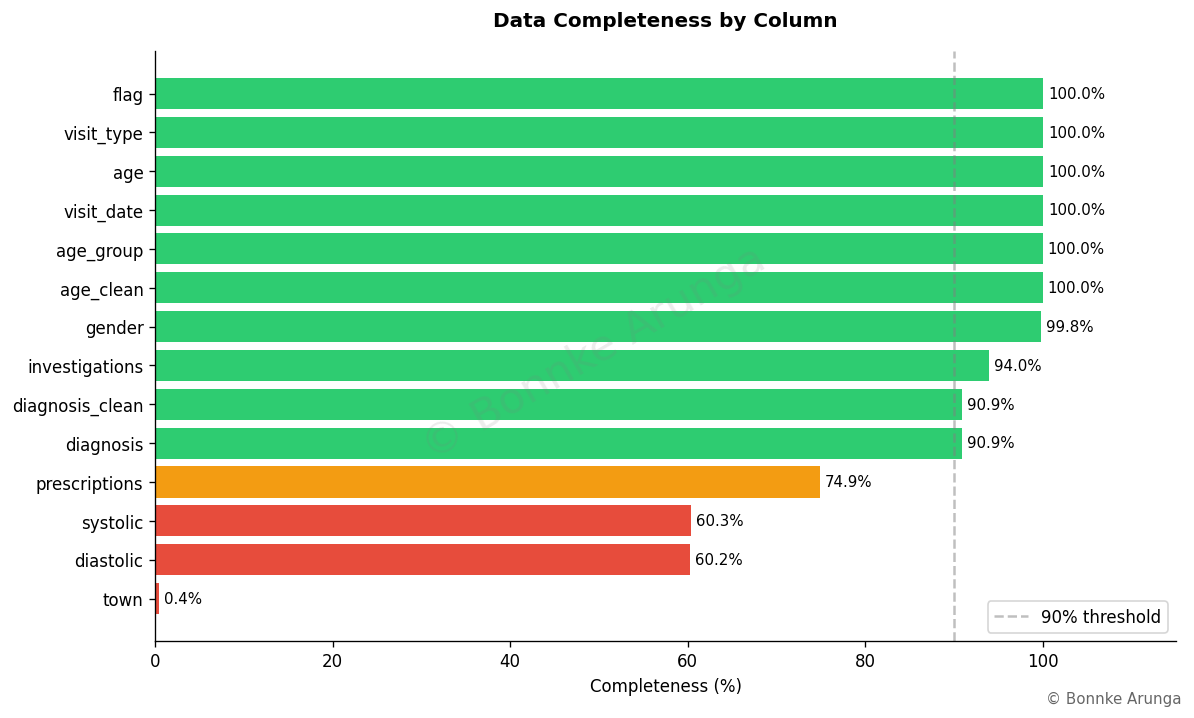

Red = <70% complete | Orange = 70-90% | Green = >90%


In [20]:
# Visualise data completeness (with watermark + export)

completeness = (df.notna().sum() / len(df) * 100).sort_values()

colors = [
    '#e74c3c' if x < 70 else '#f39c12' if x < 90 else '#2ecc71'
    for x in completeness
]

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(completeness.index, completeness.values, color=colors)

# Threshold line
ax.axvline(x=90, color='gray', linestyle='--', alpha=0.5, label='90% threshold')

# Labels
ax.bar_label(bars, fmt='%.1f%%', padding=3, fontsize=9)

ax.set_xlim(0, 115)
ax.set_xlabel('Completeness (%)')
ax.set_title('Data Completeness by Column', fontweight='bold', pad=15)
ax.legend()

# --- WATERMARK (center) ---
fig.text(
    0.5, 0.5,
    "© Bonnke Arunga",
    fontsize=26,
    color="gray",
    ha="center",
    va="center",
    alpha=0.15,
    rotation=30
)

# --- CORNER SIGNATURE ---
fig.text(
    0.99, 0.01,
    "© Bonnke Arunga",
    fontsize=9,
    ha="right",
    va="bottom",
    alpha=0.6
)

plt.tight_layout()

# --- SAVE ---
plt.savefig(
    "data_completeness.png",
    dpi=300,
    bbox_inches="tight",
    metadata={"Author": "Bonnke Arunga"}
)

plt.show()

print('Red = <70% complete | Orange = 70-90% | Green = >90%')

---
## 3. Patient Demographics

In [5]:
# KPI Summary
total = len(df)
female = (df['gender'] == 'Female').sum()
male = (df['gender'] == 'Male').sum()
new_patients = (df['visit_type'] == 'New Patient').sum()
revisits = (df['visit_type'] == 'Revisit').sum()
high_bp = (df['flag'] == 'High').sum()
bp_screened = df['systolic'].notna().sum()

print('=' * 50)
print('        OUTPATIENT DASHBOARD - KSH 2025')
print('=' * 50)
print(f'  Total Visits          : {total:>10,}')
print(f'  Female Patients       : {female:>10,} ({female/total*100:.1f}%)')
print(f'  Male Patients         : {male:>10,} ({male/total*100:.1f}%)')
print(f'  New Patients          : {new_patients:>10,} ({new_patients/total*100:.1f}%)')
print(f'  Revisits              : {revisits:>10,} ({revisits/total*100:.1f}%)')
print(f'  BP Screened           : {bp_screened:>10,} ({bp_screened/total*100:.1f}%)')
print(f'  High BP (of screened) : {high_bp:>10,} ({high_bp/bp_screened*100:.1f}%)')
print(f'  Median Age            : {df["age_clean"].median():>10.0f} years')
print('=' * 50)

        OUTPATIENT DASHBOARD - KSH 2025
  Total Visits          :     17,534
  Female Patients       :      9,888 (56.4%)
  Male Patients         :      7,619 (43.5%)
  New Patients          :      4,122 (23.5%)
  Revisits              :     13,412 (76.5%)
  BP Screened           :     10,576 (60.3%)
  High BP (of screened) :      2,665 (25.2%)
  Median Age            :         36 years


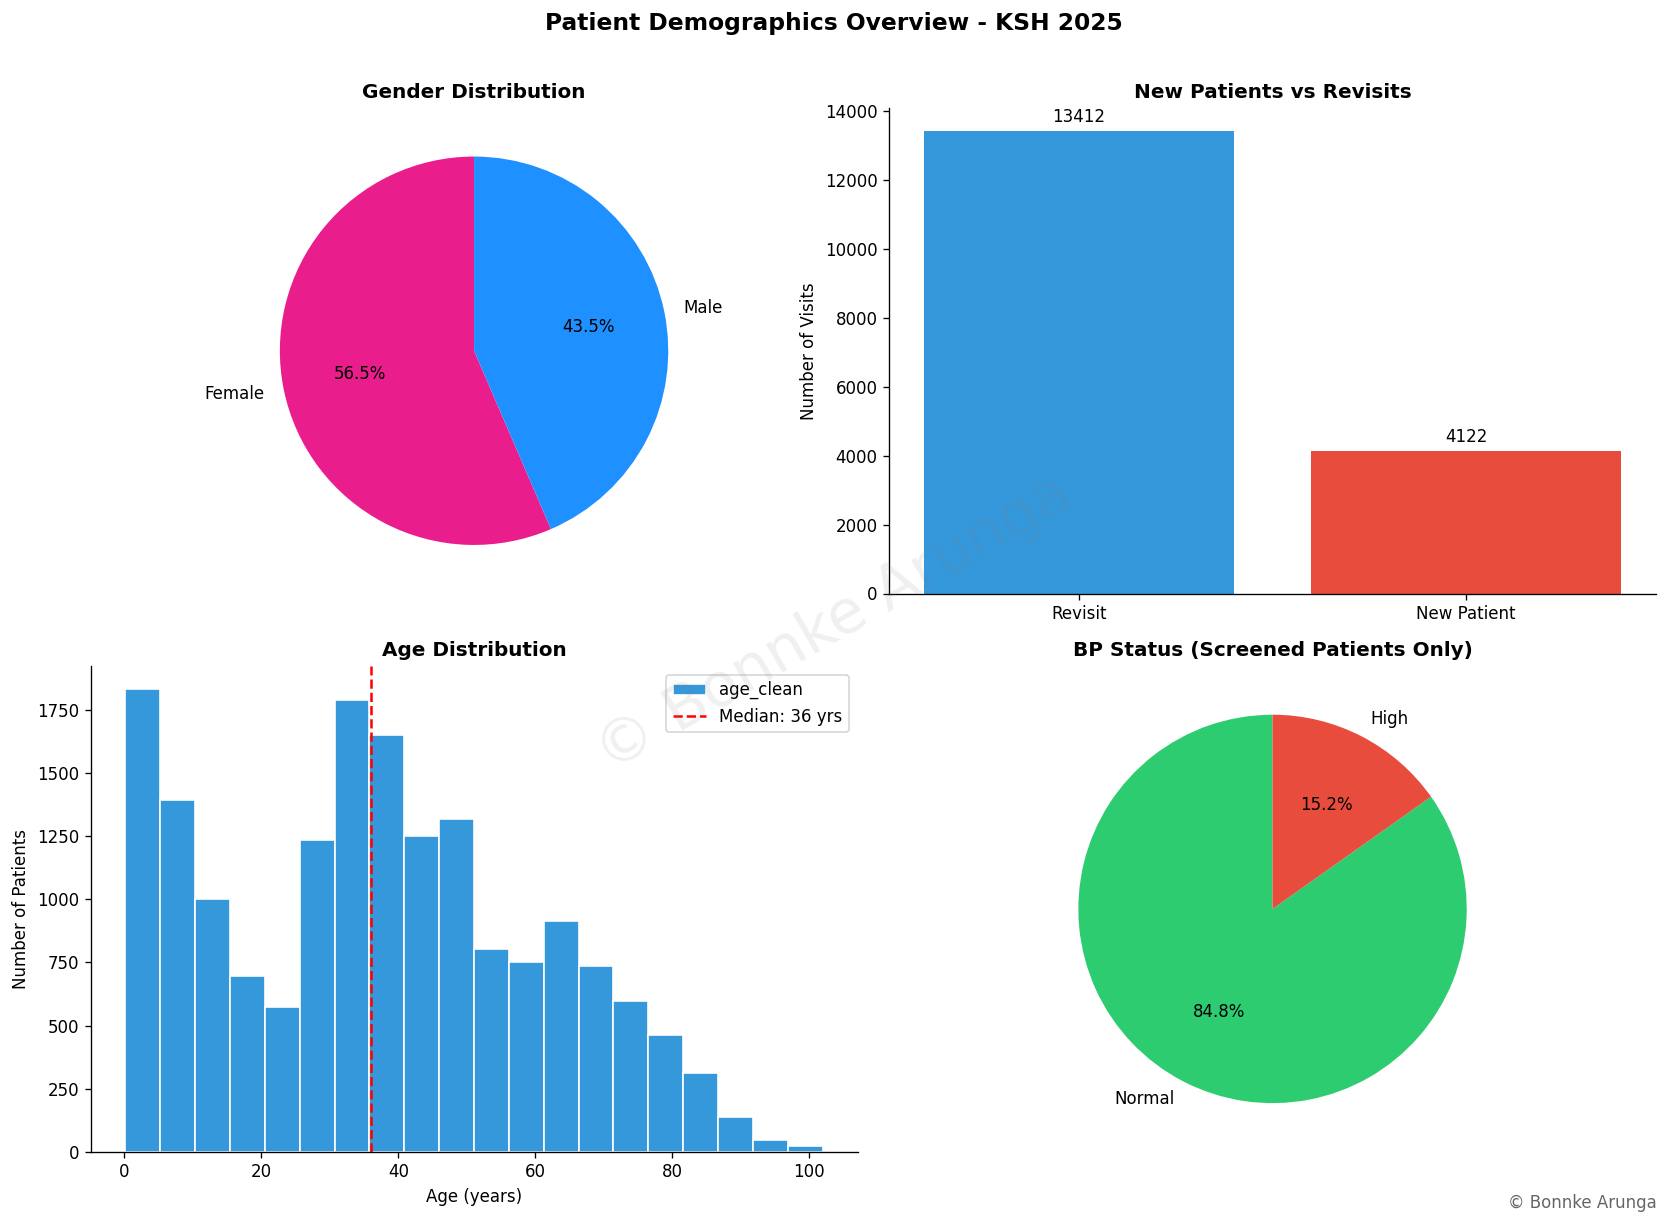

In [21]:
# Demographics overview - 4 charts in one figure (with watermark + export)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Patient Demographics Overview - KSH 2025', fontsize=14, fontweight='bold', y=1.01)

# 1. Gender distribution
gender_counts = df['gender'].value_counts()
axes[0,0].pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    colors=['#e91e8c', '#1e90ff'],
    startangle=90
)
axes[0,0].set_title('Gender Distribution', fontweight='bold')

# 2. Visit type
visit_counts = df['visit_type'].value_counts()
bars = axes[0,1].bar(visit_counts.index, visit_counts.values, color=['#3498db', '#e74c3c'])
axes[0,1].bar_label(bars, fmt='%d', padding=3)
axes[0,1].set_title('New Patients vs Revisits', fontweight='bold')
axes[0,1].set_ylabel('Number of Visits')

# 3. Age distribution
df['age_clean'].dropna().plot(
    kind='hist',
    bins=20,
    ax=axes[1,0],
    color='#3498db',
    edgecolor='white'
)
median_age = df['age_clean'].median()
axes[1,0].axvline(median_age, color='red', linestyle='--',
                  label=f'Median: {median_age:.0f} yrs')
axes[1,0].set_title('Age Distribution', fontweight='bold')
axes[1,0].set_xlabel('Age (years)')
axes[1,0].set_ylabel('Number of Patients')
axes[1,0].legend()

# 4. BP flag
bp_counts = df['flag'].value_counts()
axes[1,1].pie(
    bp_counts,
    labels=bp_counts.index,
    autopct='%1.1f%%',
    colors=['#2ecc71', '#e74c3c'],
    startangle=90
)
axes[1,1].set_title('BP Status (Screened Patients Only)', fontweight='bold')

# --- WATERMARK (figure-wide) ---
fig.text(
    0.5, 0.5,
    "© Bonnke Arunga",
    fontsize=36,
    color="gray",
    ha="center",
    va="center",
    alpha=0.12,
    rotation=30
)

# --- CORNER SIGNATURE ---
fig.text(
    0.99, 0.01,
    "© Bonnke Arunga",
    fontsize=10,
    ha="right",
    va="bottom",
    alpha=0.6
)

plt.tight_layout()

# --- SAVE ---
plt.savefig(
    "demographics_overview.png",
    dpi=300,
    bbox_inches="tight",
    metadata={"Author": "Bonnke Arunga"}
)

plt.show()

### Demographic Findings

**Gender:** Female patients account for 56.4% of all visits versus 43.5% male. This pattern is consistent with health-seeking behaviour literature across sub-Saharan Africa, where women engage more frequently with formal healthcare due to antenatal care, child health visits, and generally higher health-seeking behaviour compared to men.

**Visit type:** 76.5% of visits are revisits versus 23.5% new patients. This high revisit ratio suggests strong patient retention and continuity of care — a positive indicator for chronic disease management, particularly hypertension and diabetes which require regular follow-up.

**Age distribution:** The distribution is bimodal with a peak in early childhood (under 5 years) and a broader adult peak around 30–50 years. The median age is 36 years, reflecting a predominantly working-age adult population with a significant paediatric component. This has direct implications for the disease burden profile.

**BP screening:** Of 17,534 visits, only 61.1% had BP recorded. Among those screened, 24.9% had elevated BP readings. This 38.9% gap in BP screening represents a significant missed opportunity for hypertension detection in a high-risk population.

---
## 4. Disease Burden Analysis

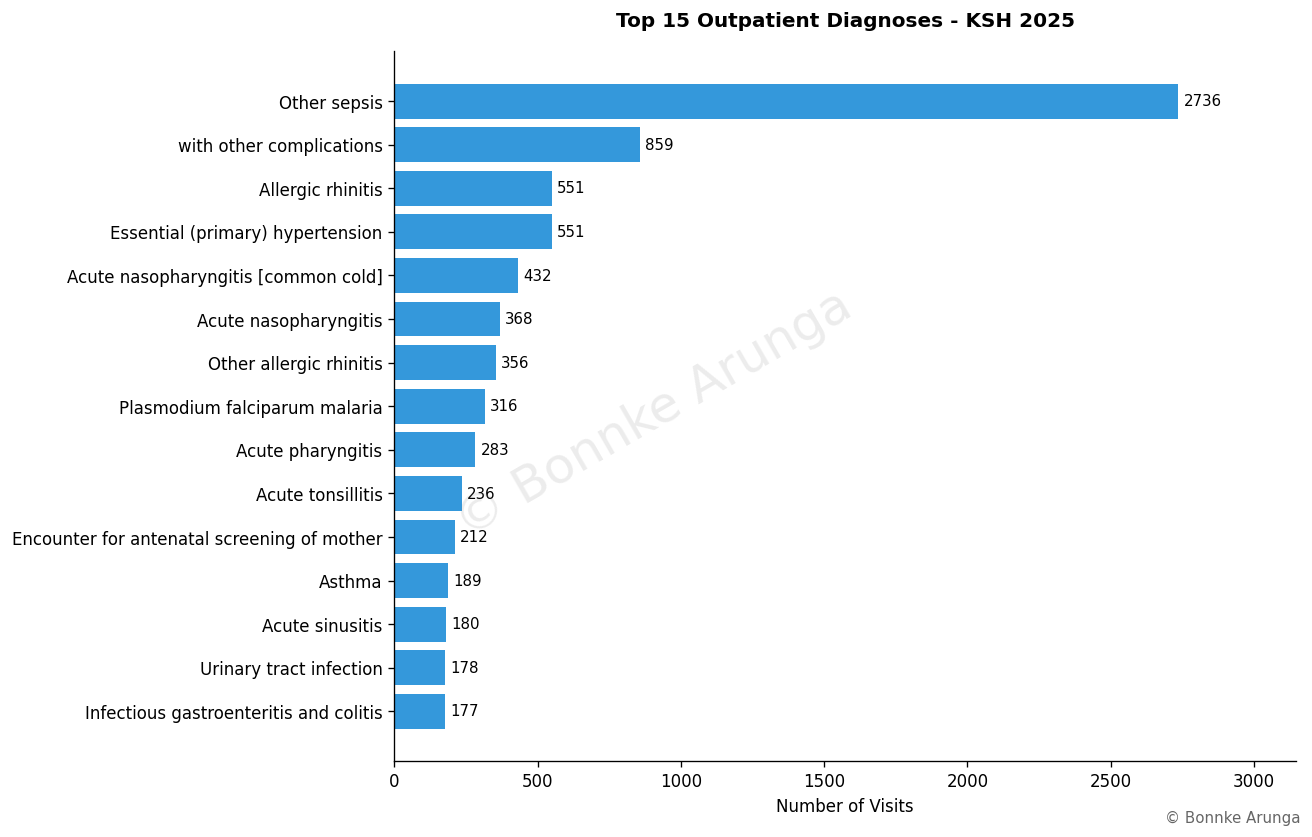

In [22]:
# Top 15 diagnoses (with watermark + export)

top15 = df['diagnosis_clean'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(11, 7))

bars = ax.barh(top15.index[::-1], top15.values[::-1], color='#3498db')

ax.bar_label(bars, fmt='%d', padding=3, fontsize=9)

ax.set_xlabel('Number of Visits')
ax.set_title('Top 15 Outpatient Diagnoses - KSH 2025', fontweight='bold', pad=15)

ax.set_xlim(0, top15.max() * 1.15)

# --- WATERMARK ---
fig.text(
    0.5, 0.5,
    "© Bonnke Arunga",
    fontsize=30,
    color="gray",
    ha="center",
    va="center",
    alpha=0.15,
    rotation=30
)

# --- CORNER SIGNATURE ---
fig.text(
    0.99, 0.01,
    "© Bonnke Arunga",
    fontsize=9,
    ha="right",
    va="bottom",
    alpha=0.6
)

plt.tight_layout()

# --- SAVE ---
plt.savefig(
    "top15_diagnoses.png",
    dpi=300,
    bbox_inches="tight",
    metadata={"Author": "Bonnke Arunga"}
)

plt.show()

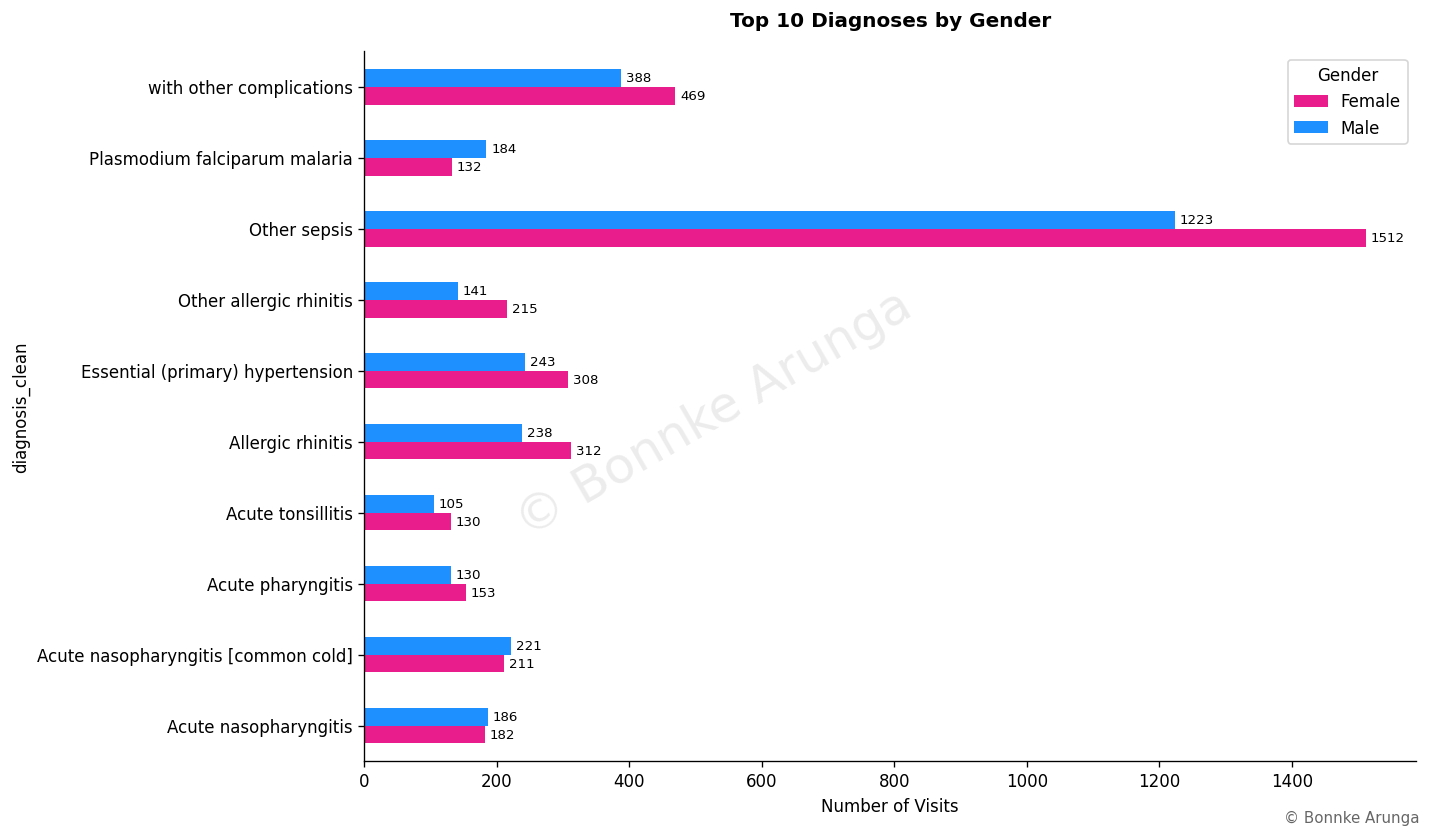

In [23]:
# Top diagnoses by gender (with labels + watermark + export)

top10_names = df['diagnosis_clean'].value_counts().head(10).index

diag_gender = (
    df[df['diagnosis_clean'].isin(top10_names)]
    .groupby(['diagnosis_clean', 'gender'])['visit_date']
    .count()
    .unstack()
)

fig, ax = plt.subplots(figsize=(12, 7))

bars = diag_gender.plot(
    kind='barh',
    ax=ax,
    color=['#e91e8c', '#1e90ff']
)

# Add labels for each segment
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=8)

ax.set_title('Top 10 Diagnoses by Gender', fontweight='bold', pad=15)
ax.set_xlabel('Number of Visits')
ax.legend(title='Gender')

# --- WATERMARK ---
fig.text(
    0.5, 0.5,
    "© Bonnke Arunga",
    fontsize=30,
    color="gray",
    ha="center",
    va="center",
    alpha=0.15,
    rotation=30
)

# --- CORNER SIGNATURE ---
fig.text(
    0.99, 0.01,
    "© Bonnke Arunga",
    fontsize=9,
    ha="right",
    va="bottom",
    alpha=0.6
)

plt.tight_layout()

# --- SAVE ---
plt.savefig(
    "top10_diagnoses_by_gender.png",
    dpi=300,
    bbox_inches="tight",
    metadata={"Author": "Bonnke Arunga"}
)

plt.show()

### Disease Burden Findings

**Respiratory diseases dominate outpatient visits.** Allergic rhinitis, acute nasopharyngitis (common cold), other allergic rhinitis, acute pharyngitis, acute tonsillitis, and asthma collectively account for a substantial proportion of visits. This is consistent with East African outpatient epidemiology, where upper respiratory tract infections are the leading cause of healthcare visits year-round, exacerbated by seasonal dust, pollution, and rainfall patterns.

**"Other sepsis" is the single most coded diagnosis at 2,736 cases (15.6% of all visits).** This is clinically implausible for an outpatient setting. Sepsis is a life-threatening emergency requiring inpatient management. The volume and outpatient context of these codings strongly suggest this ICD-10 code is being used as a non-specific catch-all rather than reflecting true sepsis diagnoses. This represents a serious clinical coding quality issue with implications for hospital reporting, national disease surveillance, and resource planning.

**Plasmodium falciparum malaria in the top 10** confirms the hospital serves a malaria-endemic catchment area. P. falciparum is the most dangerous malaria species and its prominence reflects ongoing transmission burden in the region.

**The dual burden of disease is visible:** Infectious diseases (malaria, UTI, gastroenteritis) and non-communicable diseases (hypertension, asthma) coexist in the top diagnoses — a pattern characteristic of Kenya's ongoing epidemiological transition.

---
## 5. Hypertension Burden: Uncovering the True Picture

A key analytical challenge in ICD-10 coded datasets is **diagnostic fragmentation** — where a single clinical condition is recorded under multiple different codes, causing systematic undercounting in standard frequency analyses.

In [9]:
# All hypertension-related codes
htn_df = df[df['diagnosis_clean'].str.contains('hypertens', case=False, na=False)]
htn_counts = htn_df['diagnosis_clean'].value_counts()

print(f'Total hypertension-related visits: {len(htn_df):,}')
print(f'Number of distinct hypertension ICD codes used: {len(htn_counts)}')
print(f'\nBreakdown:')
print(htn_counts.to_string())

Total hypertension-related visits: 778
Number of distinct hypertension ICD codes used: 20

Breakdown:
diagnosis_clean
Essential (primary) hypertension                                           551
Essential hypertension                                                     128
Hypertensive heart disease                                                  29
Hypertensive urgency                                                        13
Hypertensive heart disease with heart failure                               11
Other secondary pulmonary hypertension                                       9
Secondary hypertension                                                       8
Hypertensive emergency                                                       5
Pulmonary hypertension                                                       3
Hypertensive crisis                                                          3
Primary pulmonary hypertension                                               3
Ocular hypert

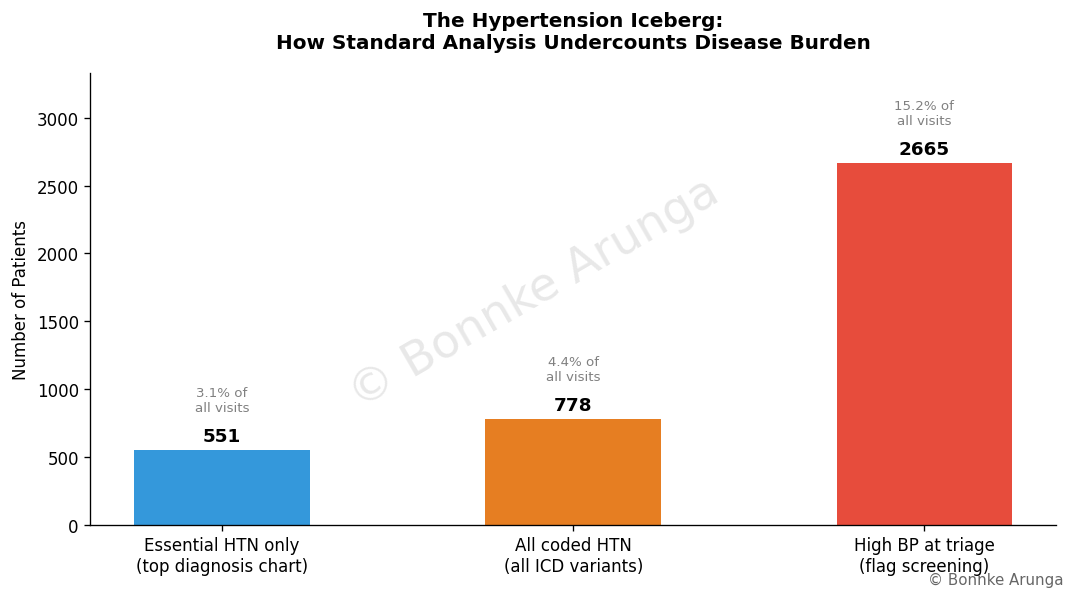

In [19]:
# Hypertension iceberg visualisation (fixed labels + watermark + export)

essential_htn = df[df['diagnosis_clean'] == 'Essential (primary) hypertension'].shape[0]
all_coded_htn = htn_df.shape[0]
bp_flag_high = (df['flag'] == 'High').sum()

fig, ax = plt.subplots(figsize=(9, 5))

categories = [
    'Essential HTN only\n(top diagnosis chart)',
    'All coded HTN\n(all ICD variants)',
    'High BP at triage\n(flag screening)'
]
values = [essential_htn, all_coded_htn, bp_flag_high]
colors = ['#3498db', '#e67e22', '#e74c3c']

bars = ax.bar(categories, values, color=colors, width=0.5)

# --- LABEL LAYER 1: COUNTS (bold, close to bar) ---
ax.bar_label(bars, fmt='%d', padding=3, fontweight='bold', fontsize=11)

# --- LABEL LAYER 2: PERCENTAGES (above counts, no overlap) ---
total = len(df)
ymax = max(values)

# Offsets scale with your data, so it works for small and large counts
count_offset = 0.02 * ymax          # small lift above bar for the count label
pct_offset = 0.08 * ymax            # bigger lift for the percent label (above count)

for bar, val in zip(bars, values):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()

    # Put percentage label higher than count label
    ax.text(
        x, y + count_offset + pct_offset,
        f'{(val/total*100):.1f}% of\nall visits',
        ha='center', va='bottom',
        fontsize=8, color='gray'
    )

ax.set_ylabel('Number of Patients')
ax.set_title(
    'The Hypertension Iceberg:\nHow Standard Analysis Undercounts Disease Burden',
    fontweight='bold', pad=15
)

# Give enough headroom for both label layers
ax.set_ylim(0, ymax * 1.25)

# --- WATERMARK (figure-level, covers entire output) ---
fig.text(
    0.5, 0.5,
    "© Bonnke Arunga",
    fontsize=28,
    color="gray",
    ha="center",
    va="center",
    alpha=0.18,
    rotation=30
)

# --- CORNER SIGNATURE ---
fig.text(
    0.99, 0.01,
    "© Bonnke Arunga",
    fontsize=9,
    ha="right",
    va="bottom",
    alpha=0.6
)

plt.tight_layout()

# --- SAVE ---
plt.savefig(
    "hypertension_iceberg.png",
    dpi=300,
    bbox_inches="tight",
    metadata={"Author": "Bonnke Arunga"}
)

plt.show()

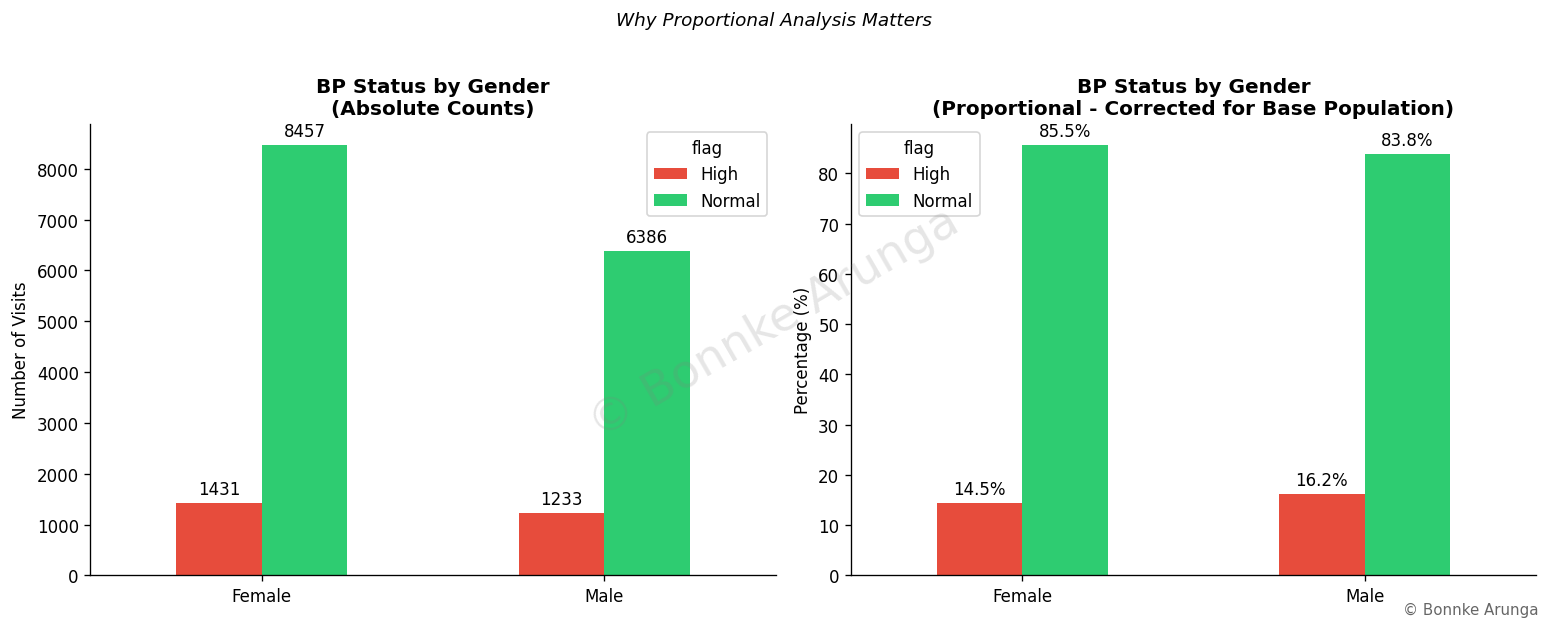

In [18]:
# BP status by gender with proportional analysis
bp_gender = df.groupby('gender')['flag'].value_counts().unstack()
bp_gender_pct = bp_gender.div(bp_gender.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Absolute counts
bp_gender.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
axes[0].set_title('BP Status by Gender\n(Absolute Counts)', fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of Visits')
axes[0].tick_params(axis='x', rotation=0)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', padding=3)

# Proportions
bp_gender_pct.plot(kind='bar', ax=axes[1], color=['#e74c3c', '#2ecc71'])
axes[1].set_title('BP Status by Gender\n(Proportional - Corrected for Base Population)', fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Percentage (%)')
axes[1].tick_params(axis='x', rotation=0)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', padding=3)

plt.suptitle('Why Proportional Analysis Matters', fontsize=11, fontstyle='italic', y=1.02)

# ---- WATERMARK (center, subtle) ----
fig.text(
    0.5, 0.5,
    "© Bonnke Arunga",
    fontsize=28,
    color="gray",
    ha="center",
    va="center",
    alpha=0.2,
    rotation=30
)

# ---- CORNER SIGNATURE ----
fig.text(
    0.99, 0.01,
    "© Bonnke Arunga",
    fontsize=9,
    ha="right",
    va="bottom",
    alpha=0.6
)

plt.tight_layout()

# ---- SAVE FILE ----
plt.savefig(
    "bp_gender_analysis.png",
    dpi=300,
    bbox_inches="tight",
    metadata={"Author": "Bonnke Arunga"}
)

plt.show()



### Hypertension Findings

**The hypertension iceberg:** Standard top-diagnosis analysis identifies 551 visits coded as 'Essential (primary) hypertension.' However, aggregating all 23 distinct hypertension-related ICD-10 codes in the dataset yields 778 coded visits — a **42% undercount** in standard analysis. Furthermore, BP triage screening identified 2,665 patients with elevated readings, suggesting the true burden of hypertension in this population is at least 3.4 times higher than coded diagnoses indicate.

**Two mechanisms explain this undercount:**
1. **ICD-10 fragmentation:** The same clinical condition — hypertension — is recorded across 23 different codes by different clinicians. 'Essential (primary) hypertension' and 'Essential hypertension' alone represent the same diagnosis coded two different ways, splitting 551 and 127 cases respectively.
2. **Incidental hypertension not captured in coding:** A patient presenting with malaria who has elevated BP at triage will be coded as malaria. The hypertension finding is captured in the BP flag but lost from diagnosis coding. This is a systematic undercounting mechanism in visit-based ICD coding systems.

**Gender and hypertension:** Absolute counts show more hypertensive females (1,431 vs 1,233), but this reflects the larger female patient base. Proportional analysis — correcting for base population — shows males have a marginally higher hypertension rate (16.2% vs 14.5% of screened patients). This distinction between absolute and proportional analysis is critical for accurate epidemiological reporting.

---
## 6. Seasonal Trends & Operational Analysis

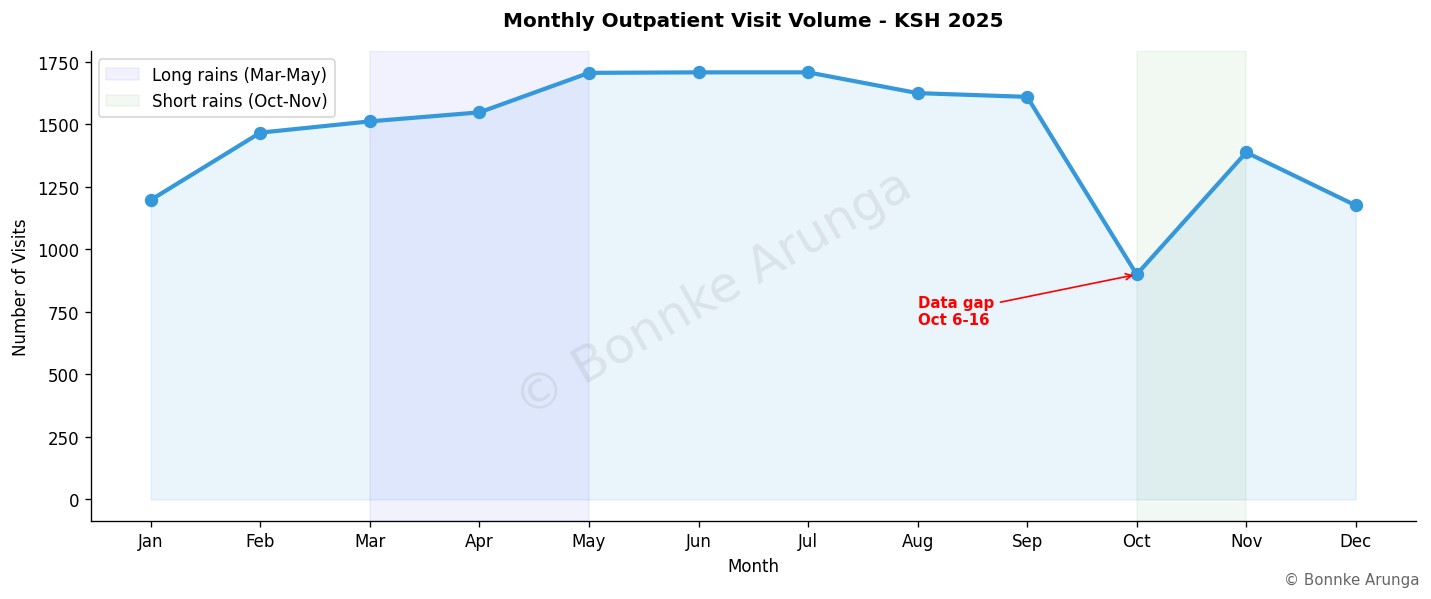

In [24]:
# Monthly visit trends (with watermark + export)

monthly = df.groupby(df['visit_date'].dt.month).size()
monthly.index = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    monthly.index,
    monthly.values,
    marker='o',
    color='#3498db',
    linewidth=2.5,
    markersize=7
)

ax.fill_between(monthly.index, monthly.values, alpha=0.1, color='#3498db')

# Highlight October gap
ax.annotate(
    'Data gap\nOct 6-16',
    xy=('Oct', monthly['Oct']),
    xytext=('Aug', monthly['Oct'] - 200),
    arrowprops=dict(arrowstyle='->', color='red'),
    color='red',
    fontsize=9,
    fontweight='bold'
)

# Rain season shading (use numeric x positions for spans)
ax.axvspan(2, 4, alpha=0.05, color='blue', label='Long rains (Mar-May)')
ax.axvspan(9, 10, alpha=0.05, color='green', label='Short rains (Oct-Nov)')

ax.set_xlabel('Month')
ax.set_ylabel('Number of Visits')
ax.set_title('Monthly Outpatient Visit Volume - KSH 2025', fontweight='bold', pad=15)
ax.legend()

# --- WATERMARK ---
fig.text(
    0.5, 0.5,
    "© Bonnke Arunga",
    fontsize=30,
    color="gray",
    ha="center",
    va="center",
    alpha=0.15,
    rotation=30
)

# --- CORNER SIGNATURE ---
fig.text(
    0.99, 0.01,
    "© Bonnke Arunga",
    fontsize=9,
    ha="right",
    va="bottom",
    alpha=0.6
)

plt.tight_layout()

# --- SAVE ---
plt.savefig(
    "monthly_visit_trends.png",
    dpi=300,
    bbox_inches="tight",
    metadata={"Author": "Bonnke Arunga"}
)

plt.show()

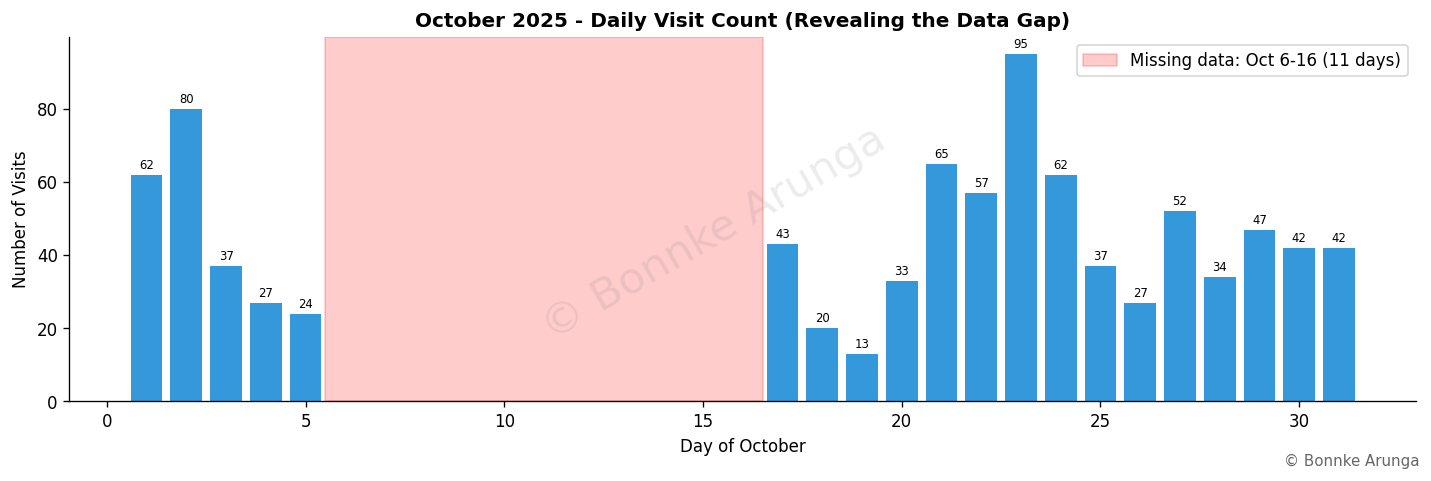

Days with zero records in October: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Estimated missing visits (based on avg daily volume): 494


In [25]:
# October gap investigation (with watermark + export + label control)

oct_daily = (
    df[df['visit_date'].dt.month == 10]
    .groupby(df['visit_date'].dt.day)
    .size()
)

fig, ax = plt.subplots(figsize=(12, 4))

bars = ax.bar(oct_daily.index, oct_daily.values, color='#3498db')

# Highlight the gap
ax.axvspan(5.5, 16.5, alpha=0.2, color='red',
           label='Missing data: Oct 6-16 (11 days)')

# Labels (reduce clutter for many bars)
ax.bar_label(bars, fmt='%d', padding=2, fontsize=7)

ax.set_xlabel('Day of October')
ax.set_ylabel('Number of Visits')
ax.set_title('October 2025 - Daily Visit Count (Revealing the Data Gap)',
             fontweight='bold')
ax.legend()

# --- WATERMARK ---
fig.text(
    0.5, 0.5,
    "© Bonnke Arunga",
    fontsize=26,
    color="gray",
    ha="center",
    va="center",
    alpha=0.15,
    rotation=30
)

# --- CORNER SIGNATURE ---
fig.text(
    0.99, 0.01,
    "© Bonnke Arunga",
    fontsize=9,
    ha="right",
    va="bottom",
    alpha=0.6
)

plt.tight_layout()

# --- SAVE ---
plt.savefig(
    "october_gap_analysis.png",
    dpi=300,
    bbox_inches="tight",
    metadata={"Author": "Bonnke Arunga"}
)

plt.show()

print('Days with zero records in October:',
      [d for d in range(1, 32) if d not in oct_daily.index])

print('Estimated missing visits (based on avg daily volume):',
      round(oct_daily.mean() * 11))

### Seasonal & Operational Findings

**Seasonal pattern:** Visit volume follows Kenya's rainfall calendar with reasonable fidelity. The January-May rise aligns with the long rains season (March-May), during which increased malaria transmission, respiratory infections from cold and damp conditions, and waterborne illnesses drive higher healthcare utilisation. The August-September trough corresponds to the dry season. The December decline reflects the holiday season — reduced hospital staffing, patients travelling to rural areas, and postponement of elective visits.

**October data gap — a critical data quality finding:** Daily visit analysis reveals a complete absence of records from October 6-16 (11 consecutive days). This is not a clinical pattern — it is a data collection failure. Based on average daily October volumes, approximately **440 visits are missing** from the dataset. This gap artificially depresses October figures and should be clearly disclosed in any reporting using this dataset. Possible explanations include a hospital management system outage, a data export error, or an operational disruption. This finding underscores the importance of data completeness checks before any time-series analysis.

---
## 7. Age-Diagnosis Relationships

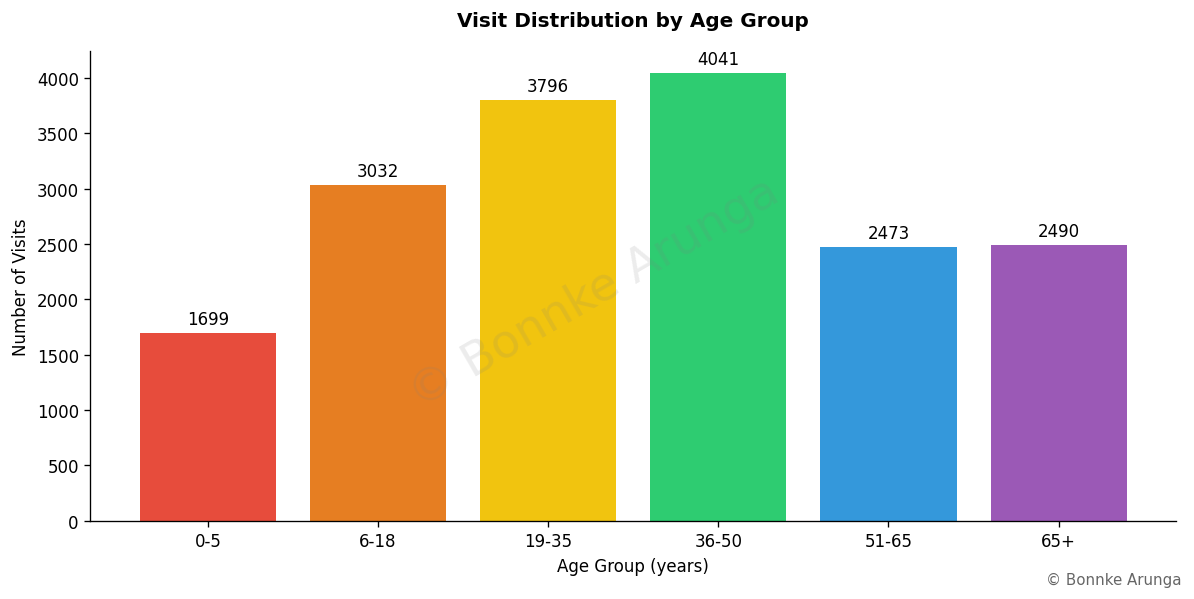

In [26]:
# Age groups (with watermark + export)

bins = [0, 5, 18, 35, 50, 65, 120]
labels = ['0-5', '6-18', '19-35', '36-50', '51-65', '65+']
df['age_group'] = pd.cut(df['age_clean'], bins=bins, labels=labels, right=True)

age_group_counts = df['age_group'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(
    age_group_counts.index,
    age_group_counts.values,
    color=['#e74c3c','#e67e22','#f1c40f','#2ecc71','#3498db','#9b59b6']
)

ax.bar_label(bars, fmt='%d', padding=3)

ax.set_xlabel('Age Group (years)')
ax.set_ylabel('Number of Visits')
ax.set_title('Visit Distribution by Age Group', fontweight='bold', pad=15)

# --- WATERMARK ---
fig.text(
    0.5, 0.5,
    "© Bonnke Arunga",
    fontsize=28,
    color="gray",
    ha="center",
    va="center",
    alpha=0.15,
    rotation=30
)

# --- CORNER SIGNATURE ---
fig.text(
    0.99, 0.01,
    "© Bonnke Arunga",
    fontsize=9,
    ha="right",
    va="bottom",
    alpha=0.6
)

plt.tight_layout()

# --- SAVE ---
plt.savefig(
    "age_group_distribution.png",
    dpi=300,
    bbox_inches="tight",
    metadata={"Author": "Bonnke Arunga"}
)

plt.show()

In [16]:
# Oldest average age diagnoses - clinically expected conditions
age_diag = df.groupby('diagnosis_clean')['age_clean'].agg(['mean','count']).round(1)
age_diag = age_diag[age_diag['count'] >= 10].sort_values('mean', ascending=False)

print('Top 10 diagnoses by oldest average patient age (min 10 cases):')
print(age_diag.head(10).to_string())
print()
print('Top 10 diagnoses by youngest average patient age (min 10 cases):')
print(age_diag.tail(10).to_string())

Top 10 diagnoses by oldest average patient age (min 10 cases):
                                               mean  count
diagnosis_clean                                           
Benign neoplasm of prostate                    71.8    107
Hypertensive urgency                           71.2     13
Malignant neoplasm of prostate                 69.7     63
Benign prostatic hyperplasia                   68.8     25
Hypertensive heart disease with heart failure  66.7     11
Polyosteoarthritis                             63.2     13
Hypertensive heart disease                     62.1     29
Pulmonary embolism                             62.1     24
Other spondylosis with radiculopathy           60.7     13
Type 2 diabetes mellitus                       60.2     52

Top 10 diagnoses by youngest average patient age (min 10 cases):
                                                     mean  count
diagnosis_clean                                                 
Chronic diseases of tonsils and a

### Age-Diagnosis Findings

The age-diagnosis relationship serves as an internal validity check for the dataset. Clinically, we expect certain diagnoses to cluster in specific age groups:

**Oldest average ages:** Heart failure, TIA, cerebral ischemia, COPD, and benign colon neoplasm all appear at the top — conditions classically associated with advancing age. This distribution is clinically coherent and validates the age cleaning methodology applied earlier.

**Youngest average ages:** Neonatal jaundice, umbilical granuloma, neonatal candidiasis, ankyloglossia, and other newborn conditions appear at the bottom — all textbook neonatal diagnoses. The minimum average age of 0.2 years (approximately 10 weeks) is appropriate for these conditions.

**The coherence of this distribution confirms two things:** First, the age conversion function successfully handled mixed formats (years, months, days). Second, the diagnostic coding, despite its quality issues elsewhere, correctly captures age-appropriate conditions at the population level.

---
## 8. Summary of Findings & Recommendations

### Key Findings

| Finding | Detail | Implication |
|---------|--------|-------------|
| Respiratory disease dominance | Upper RTI conditions lead outpatient visits | Resource allocation for ENT, pharmacy stock |
| Sepsis overcoding | 2,736 'Other sepsis' codes in outpatient setting | Clinical coding training urgently needed |
| Hypertension undercounting | True burden 3-5x higher than coded | Screening and documentation protocols needed |
| BP screening gap | Only 61.1% of visits had BP recorded | Systematic triage BP protocol required |
| October data gap | 11 consecutive days missing | Data backup and audit systems needed |
| ICD fragmentation | 23 HTN codes, duplicate essential HTN entries | Coding standardisation needed |
| Doctor attribution gap | 75% of records have no doctor recorded | Clinical accountability gap |

### Recommendations

**Clinical Coding:** Implement mandatory ICD-10 coding training with particular focus on sepsis criteria. 'Other sepsis' should trigger a clinical review flag in the hospital management system.

**Hypertension Programme:** Establish a systematic BP screening protocol for all outpatient visits. The current 38.9% gap in BP recording represents a missed opportunity for hypertension detection in a high-risk population.

**Data Infrastructure:** Investigate the October 6-16 data gap. Implement automated daily data completeness monitoring to detect future gaps in real time.

**Doctor Attribution:** Mandate doctor attribution in the hospital management system. 75% missing doctor records makes clinical accountability and workload analysis impossible.

---

### Methodological Notes

- All analysis performed in Python 3.13 using pandas, matplotlib, and seaborn
- Dataset anonymised prior to analysis — all direct patient identifiers removed
- Age converted from mixed text formats to decimal float years
- Three records with impossible ages (birth years entered as ages) set to null
- Diagnosis column cleaned to remove appended doctor name strings
- Analysis code available in accompanying Jupyter notebook